In [1]:
# out of the box python modules
import sqlite3
import os

# some
from src.models.make_model import MyModelStruct

# Data wrangling stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# Neural network stuff
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, r2_score, rmse


rc('mathtext', default='regular')

%load_ext dotenv
%dotenv

DATABASE_PATH = os.environ['DATABASE_PATH']
MODEL_STORE_PATH = os.environ['MODEL_STORE']

In [2]:
with sqlite3.connect(DATABASE_PATH) as conn:
    cur = conn.cursor()
    res = cur.execute("SELECT * FROM market_data where date >= '2022-09-01' order by ticker, date;")
    entries = res.fetchall()

full_dataset = pd.DataFrame(entries, columns=['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits'])
full_dataset['date'] = pd.to_datetime(full_dataset['date'])
full_dataset['avg_price'] = full_dataset[['open', 'high', 'low', 'close']].mean(axis=1)
full_dataset['paid_dividends'] = full_dataset['dividends'].replace(0, np.nan)
full_dataset['period'] = full_dataset.date.dt.to_period('Q')
sample = full_dataset.query("ticker == 'FIBRAPL14.MX'").get(['date', 'ticker', 'avg_price'])

In [3]:
# sample['avg_price'] = sample.avg_price.diff()
# sample.dropna(subset=['avg_price'], inplace=True)

# Train a model from scratch

In [4]:
struct = MyModelStruct(ticker='FIBRAPL14', model_type='price', dataset=sample, scaler=Scaler())
struct.set_model()
struct.set_train_test_data(train_size=0.85)
struct.train_model()
struct.run_backtest()
struct.run_prediction(window=20, series=struct.val_scaled)
struct.append_prediction()

Found an existing model for this. Use load_model method to use it or continue with training to replace it


c:\Users\alanc\miniconda3\envs\fibra_analyzer_env\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | res_blocks    | ModuleList       | 1.4 K 
---------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
c:\Users\alanc\miniconda3\envs\fibra_analyzer_env\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


rmse: 3.6235508031426065
mape: 4.7508475259928495
r2_score: -0.48171070091088386


<AxesSubplot:xlabel='date'>

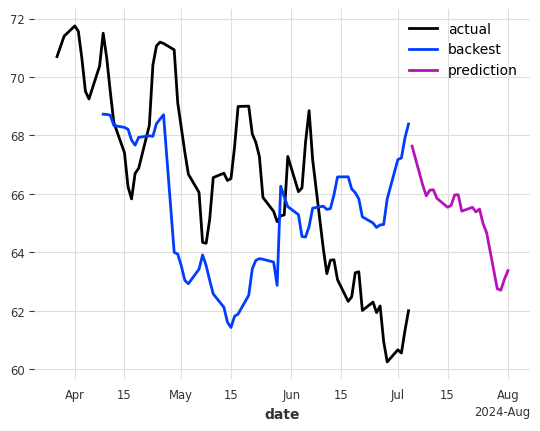

In [5]:
print('rmse:', rmse(struct.val, struct.reversed_backtest))
print('mape:', mape(struct.val, struct.reversed_backtest))
print('r2_score:', r2_score(struct.val, struct.reversed_backtest))

struct.val.plot(label="actual")
struct.reversed_backtest.plot(label="backest")
struct.reversed_prediction.plot(label="prediction")

In [6]:
struct.get_aggregated_dataset()

component,date,avg_price,source
0,2024-03-27,70.697982,actual
1,2024-03-28,71.047569,actual
2,2024-03-29,71.397155,actual
3,2024-04-01,71.746741,actual
4,2024-04-02,71.565746,actual
...,...,...,...
87,2024-07-26,64.671792,prediction
88,2024-07-29,62.752582,prediction
89,2024-07-30,62.703224,prediction
90,2024-07-31,63.073173,prediction


In [7]:
# struct.ts_dataset[-60:].plot(label="actual");

In [8]:
# struct.save_model()
# struct.save_scaler()